# Chapter 2. 다양한 패턴의 2차원 상의 점을 구분해 내는 방법

## Step 0. 데이터 소개 및 학습목표

**데이터는 아래와 같은 생성 데이터를 기반으로 합니다.**



- 선형 관계를 가진 클러스터: 하나의 직선으로 두 군집을 나눌수 있는 관계


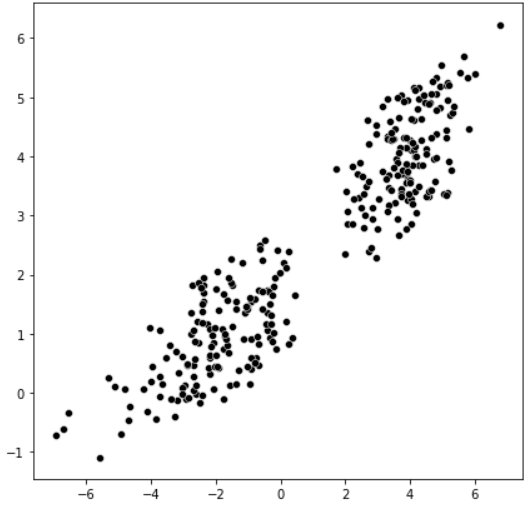

- 비선형 관계를 가진 클러스터 :직선으로는 군집을 나눌 수 없는 관계
 - Concentric circles 동심원
 - Interleaving half circles
 - Spiral
-> Logistic regression 등 선형이 가정된 모델로는 도저히 찾을 수 없다
-> 이런 비선형 관계들을 선형패턴으로 전처리를 하면 학습 속도, 정확성이 올라감
-> Neural 네트워크등으로 바로 풀어낼 수도 있으나 convergence 이슈가 들어가게 됨
-> 정확히 우리가 알아낼수 잇는 이슈가 무엇인지 모르는 상태일때 선형패턴을 최대한 만들면 우리가 예측하고자하는 바를 좀 더 구체화 할 수 있다 (딥러닝도 예외는 아님)

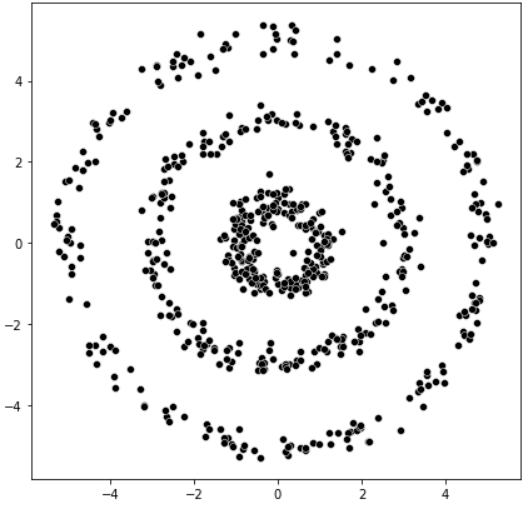

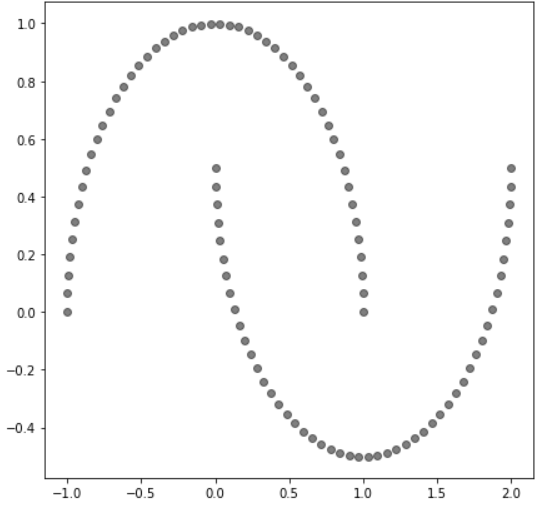

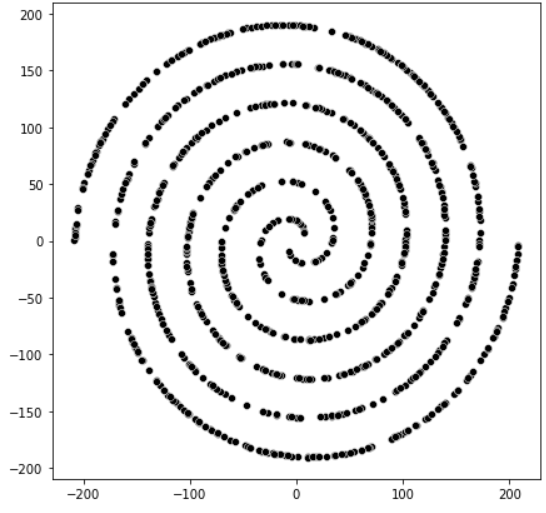

- 아래는 데이터를 생성할 때 가정된 클러스터 정보입니다


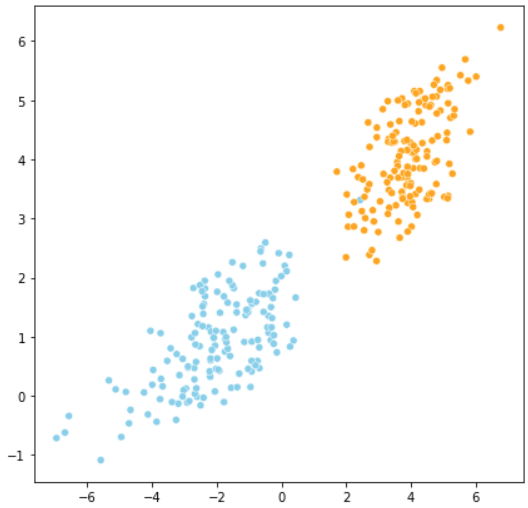

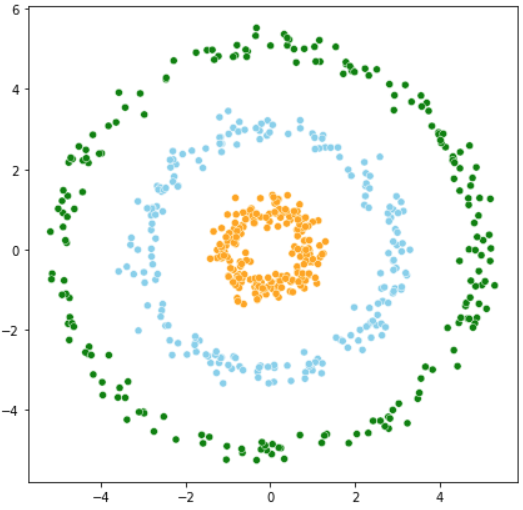

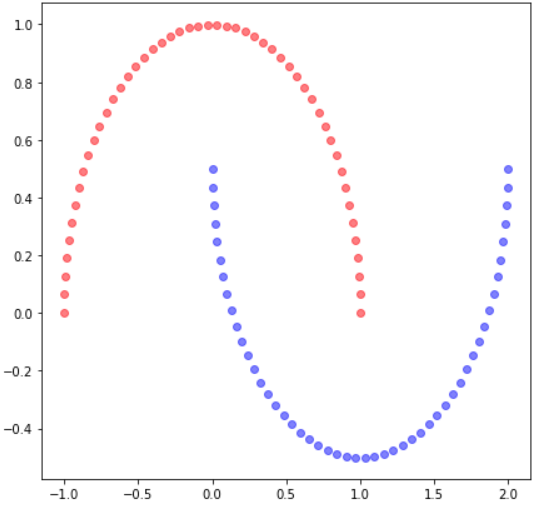

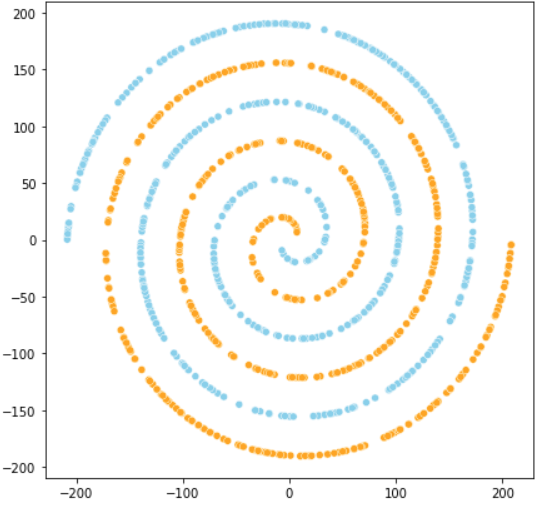

- 설명변수만을 가지고 다양한 데이터의 패턴을 잡아내어 클러스터를 구분해내거나 차원을 축소하는 것이 본 강의의 목적입니다.
- 비지도적 학습방법을 활용하여 데이터 생성시에 가정된 클러스터 정보와 최대한 비슷하게 클러스터를 구분해 내고자 하며, 이를 위하여 Principal Component를 활용합니다.


### **학습목표**
```
- 비지도학습의 개념을 이해.
- Principal Component에 대한 개념과 목적을 이해.
- 선형 패턴과 비선형 패턴의 차이와 이에 따른 접근방법 이해.
- 비선형 패턴 데이터를 다루기 위한 Kernel PCA 이해.
- 분석 상황에서의 Principal Componenet 활용.
``` 

##Step 1. 패턴 데이터 생성

###문제 1. 그림을 바탕으로 데이터 생성하기 - 선형 관계

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_circles, make_classification

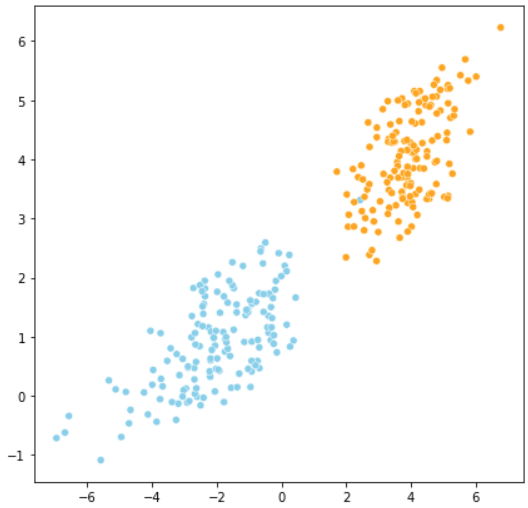

In [2]:
##(문제) sklearn.datasets.make_classification을 활용하여 위의 그림과 같은 데이터를 생성합니다.
# 두 클러스터를 모두 합쳐 관측치의 개수는 300개입니다.
# 두 클러스터가 대부분의 점들이 잘 구분되며 두 클러스터 모두 우상향 하는 모습을 가져야 합니다. 데이터가 정확히 같을 필요는 없습니다.
X_1, y_1 = make_classification(n_samples=300,n_features=2,n_redundant=0 , n_informative=2, random_state=1, n_clusters_per_class=1, n_classes=2, class_sep=3) #클래스 두개가 나눠지도록 정보를 줌
X_1[:,1] = (X_1[:,0]+X_1[:,1])/2 #컬럼간 연관을 주기위해 합친다음 평균을 내줌
rng = np.random.RandomState(2) #에러텀
X_1 += 2*rng.uniform(size = X_1.shape) #
#X_1, y_1 = make_classification(n_sample=300, n_features = 2, n_redundant=0, n_informative=2, random_state = 1, n_clusters_per_class=1, n_classes= 2, class_sep = 3)

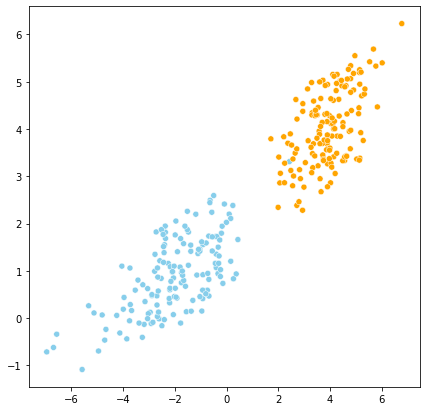

In [3]:
## (문제) seaborn.scatterplot을 이용하고 아래의 color_code와 plot 세팅을 활용하여 플랏을 그립니다.
color_code = {0:'Orange', 1:'Skyblue'}
plt.figure(figsize=(7,7))

sns.scatterplot(x = X_1[:,0], y = X_1[:,1], c = [color_code.get(i) for i in y_1] ) 
#plt.show()

### 문제 2. 그림을 바탕으로 데이터 생성하기 - 비선형 관계

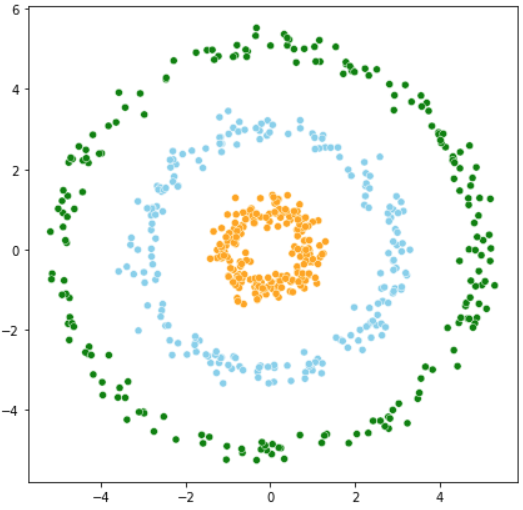

In [4]:
##(문제) (x,y)=(r*cos(theta),r*sin(theta))임을 활용하여 위의 그림과 같은 데이터를 생성합니다.

np.random.seed(1)
def CircleXY(r, n, sigma): #sigma : 얼마나 에러를 줄것인가 (작게할수록 동심원 중심에 좀더 오밀조밀하게 모임)
    theta = np.random.uniform(low=0, high=2*np.pi, size=n)
    x_error = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_error = np.random.normal(loc=0.0, scale=sigma, size=n)

    x_val = r*np.cos(theta) + x_error
    y_val = r*np.sin(theta) + y_error
    return x_val, y_val, np.repeat(r, n)


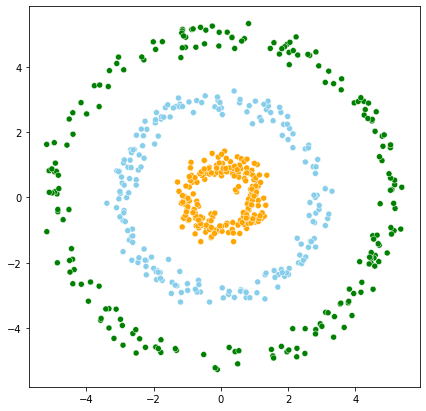

In [5]:
##(문제) seaborn.scatterplot을 이용하고 아래의 파라미터들을 활용하여 Concentric circles 플랏을 완성합니다.
plt.figure(figsize=(7,7))
n = 200
r_list =[1, 3, 5]
sigma = 0.2
param_lists = [(r, n, sigma) for r in r_list] #반지름 별로 각 원에대한 리스트를 만듬
coordinates = [ CircleXY(param[0], param[1], param[2])  for param in param_lists] #각 반지름 별로 점들을 생성해줌
color_code = {1:'Orange', 3:'Skyblue', 5:'Green'} #각 반지름 별로 색을 부여해줌


for j in range(0, len(coordinates)):
  x,y, group = coordinates[j]
  sns.scatterplot(x = x, y = y, c = [color_code.get(i) for i in group])
plt.show()

In [6]:
# 아래와 같이 데이터를 정리합니다.
X1,X2,y_2_bf=[ np.append(np.append(coordinates[0][i],coordinates[1][i]),coordinates[2][i])  for i in range(0,3)] #각 설명변수별로 좌표들을 넣어줌
X_2=np.c_[X1,X2] 
mapping_dic = {1:0, 3:1, 5:2} #반지름이 작은 순서부터 인덱스를 넣어줌
y_2_bf2=[mapping_dic.get(i) for i in y_2_bf] 
y_2=np.array(y_2_bf2) 

##Step 2. 전통적 clustering을 통한 접근

###문제 3. [K-means] K-means clustering - 기본 모형 생성 (선형 관계) 

- K-means 알고리즘

 (1) 중심점 (X 표시)을 임의로 선정. (그림 a)

 (2) 각 데이터 포인트에 대해 가장 가까운 중심점을 찾고, 해당 군집을 할당. (그림 b)

 (3) 할당된 군집을 기반으로 새로운 중심점을 계산. (그림 c)
 
 (4) 각 클러스터의 할당이 바뀌지 않을 때까지 (2),(3) 반복.

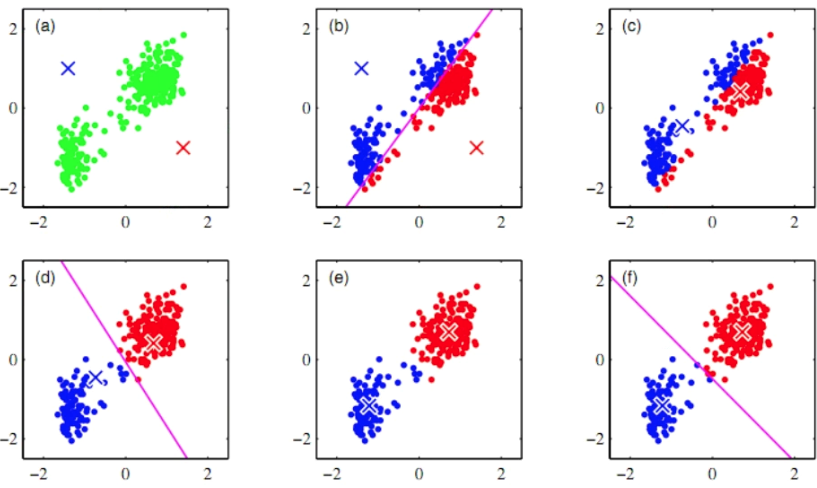

Image reference: Bishop, C. M. (2006). Pattern recognition and machine learning. springer.

In [7]:
from sklearn.cluster import KMeans

In [8]:
## (문제) sklearn.cluster.KMeans를 활용하여 클러스터링을 진행하여 km에 저장합니다. n_clusters = 3, random_state=1 으로 지정합니다.
# centers에 클러스터별 중심값을 저장하고, y_km에  cluster 정보를 저장합니다.
km = KMeans(n_clusters = 3, random_state=0)
km.fit(X_1)
centers = km.cluster_centers_
y_km = km.labels_

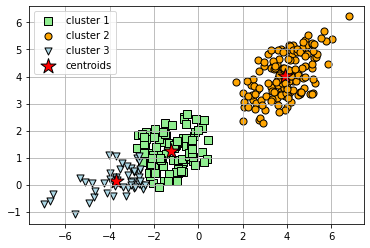

In [9]:
# 아래 코드를 활용해 플랏을 그립니다.
plt.scatter(
    X_1[y_km == 0, 0], X_1[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X_1[y_km == 1, 0], X_1[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X_1[y_km == 2, 0], X_1[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

###문제 4. [K-means] K-means clustering - 최적의 k 찾기 (선형 관계) 

In [10]:
## (문제) sklearn.cluster.KMeans를 fit한 후 이것의 inertia_를 활용하여 플랏을 그리고 elbow method 를 활용하여 적정 k를 구합니다.
# 고려하는 k는 1에서 10까지로 합니다. KMeans 함수에 random_state=1 옵션을 적용합니다.

distortions=[]
for i in range(1,11):
  km=KMeans( n_clusters=i, random_state=1)
  km.fit(X_1)
  distortions.append(km.inertia_)


In [11]:
distortions #클러스터가 많아지면 줄어든다.(클러스터간의 거리 대비 클러스터와 샘플들의 거리. 클러스터끼리는 멀고, 클러스터 안은 잘 모여있을때 값이 작다)
#클러스터가 크면 무조건 작기 때문에, 급격히 작아지는 구간을 K로 설정해준다

[4003.9465338062914,
 639.6944972510703,
 409.99949723676724,
 299.58672069789156,
 223.75497718336118,
 185.10323011049246,
 154.36325491395064,
 133.32899316089356,
 117.22310046470062,
 106.76362572560028]

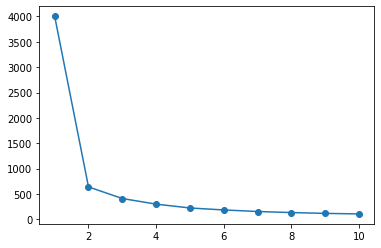

In [12]:
plt.plot(range(1,11),distortions,marker = 'o')
#기울기가 완만해 진 지점(이전엔 경사가 급했던 곳) -> 팔꿈치같음 (elbow method) 여기서는 클러스터 2,3이 좋아보임(2가 최고)

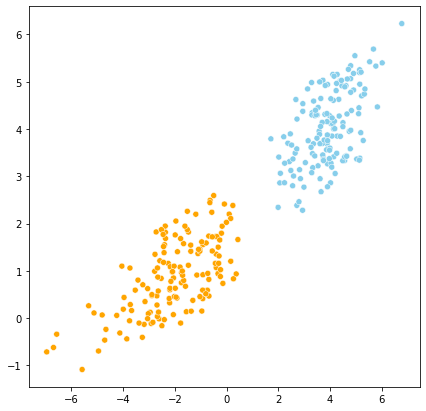

In [13]:
## (문제) seaborn.scatterplot을 이용하고 위의 클러스터링 결과를 활용하여 클러스터별 color_code를 적용하고 플랏을 그립니다.
color_code = {0:'Orange', 1:'Skyblue'}
plt.figure(figsize=(7,7))

km=KMeans(n_clusters=2 , random_state=1) #k =2로 설정하여 군집을 나눠줘본다
km.fit(X_1)
y_km=km.labels_

sns.scatterplot(x=X_1[:,0],y=X_1[:,1],c=[color_code.get(i) for i in y_km])
plt.show()

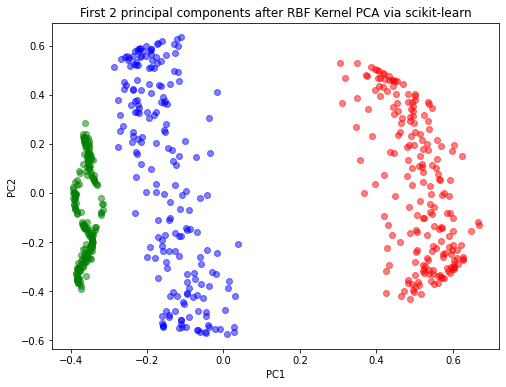

In [14]:
from sklearn.decomposition import KernelPCA
c=0.08
sigmaval=np.sqrt(c/2)


scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=sigmaval)
X_skernpca = scikit_kpca.fit_transform(X_2)

plt.figure(figsize=(8,6))
plt.scatter(X_skernpca[y_2==0, 0], X_skernpca[y_2==0, 1], color='red', alpha=0.5)
plt.scatter(X_skernpca[y_2==1, 0], X_skernpca[y_2==1, 1], color='blue', alpha=0.5)
plt.scatter(X_skernpca[y_2==2, 0], X_skernpca[y_2==2, 1], color='green', alpha=0.5)

plt.title('First 2 principal components after RBF Kernel PCA via scikit-learn')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
from sklearn.datasets import make_moons
X_4, y_4 = make_moons(n_samples=100, random_state=123)

In [ ]:
plt.figure(figsize=(7,7))

plt.scatter(X_4[y_4==0, 0], X_4[y_4==0, 1], color='red', alpha=0.5)
plt.scatter(X_4[y_4==1, 0], X_4[y_4==1, 1], color='blue', alpha=0.5)

plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X_4)

plt.figure(figsize=(8,6))
plt.scatter(X_skernpca[y_4==0, 0], X_skernpca[y_4==0, 1], color='red', alpha=0.5)
plt.scatter(X_skernpca[y_4==1, 0], X_skernpca[y_4==1, 1], color='blue', alpha=0.5)

plt.text(-0.48, 0.35, 'gamma = 15', fontsize=12)
plt.title('First 2 principal components after RBF Kernel PCA via scikit-learn')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/P3C2/"
sys.path.insert(0, path)

In [ ]:
!pip install git+https://github.com/lovit/synthetic_dataset

In [ ]:
from soydata.data import *
from soydata.visualize import *
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X_3, y_3 = classification.make_spiral(n_samples_per_class=500, n_classes=2,
n_rotations=3, gap_between_spiral=10, 
gap_between_start_point=1, equal_interval=True,                
noise=0.1)

In [ ]:
plt.figure(figsize=(7,7))
color_code2 = {0:'Orange', 1:'Skyblue', 2:'Green'}
sns.scatterplot(x=X_3[:,0], y=X_3[:,1], c=[color_code2.get(i) for i in y_3])  
plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA
g_start=-50
g_end=50
g_power= np.arange(g_start,g_end,(g_end-g_start)/25)
color_code = {0:'Orange', 1:'Skyblue'}
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(30,30), sharex=False, sharey=False)

for n, ax in enumerate(axs.flatten()):
    g_value=10**(g_power[n])
    scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=g_value)
    X_skernpca = scikit_kpca.fit_transform(X_3)
    ax.scatter(X_skernpca[:, 0], X_skernpca[:, 1], color=group_color, alpha=0.5)
    ax.set_title('Power of gamma: ' + str(g_power[n]) +"", size = 12)

plt.show()





In [ ]:
from sklearn.decomposition import KernelPCA
g_start=-6
g_end=2
g_power= np.arange(g_start,g_end,(g_end-g_start)/25)
color_code = {0:'Orange', 1:'Skyblue'}
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(30,30), sharex=False, sharey=False)

for n, ax in enumerate(axs.flatten()):
    g_value=10**(g_power[n])
    scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=g_value)
    X_skernpca = scikit_kpca.fit_transform(X_3)
    ax.scatter(X_skernpca[:, 0], X_skernpca[:, 1], color=group_color, alpha=0.5)
    ax.set_title('Power of gamma: ' + str(g_power[n]) +"", size = 12)
    
plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA
g_start=-2.5
g_end=-1.8
g_power= np.arange(g_start,g_end,(g_end-g_start)/25)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(30,30), sharex=False, sharey=False)
color_code = {0:'Orange', 1:'Skyblue'}

for n, ax in enumerate(axs.flatten()):
    g_value=10**(g_power[n])
    scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=g_value)
    X_skernpca = scikit_kpca.fit_transform(X_3)
    ax.scatter(X_skernpca[:, 0], X_skernpca[:, 1], color=group_color, alpha=0.5)
    ax.set_title('Power of gamma: ' + str(g_power[n]) +"", size = 12)
    
plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA
g_power_val=-2.3
g_value=10**(g_power_val)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=g_value)
X_skernpca = scikit_kpca.fit_transform(X_3)

color_code = {0:'Orange', 1:'Skyblue'}
group_color=[color_code.get(i) for i in y_3]
plt.scatter(X_skernpca[:, 0], X_skernpca[:, 1], color=group_color, alpha=0.3)
    
plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA
g_start=17
g_end=27
g_power= np.arange(g_start,g_end,(g_end-g_start)/10)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(30,15), sharex=False, sharey=False)
color_code = {0:'Orange', 1:'Skyblue'}

for n, ax in enumerate(axs.flatten()):
    print(g_power[n])
    scikit_kpca = KernelPCA(n_components=2, kernel='poly', degree=g_power[n])
    X_skernpca = scikit_kpca.fit_transform(X_3)
    ax.scatter(X_skernpca[:, 0], X_skernpca[:, 1], color=group_color, alpha=0.5)
    ax.set_title('Degree: ' + str(g_power[n]) +"", size = 12)
    
plt.show()

In [ ]:
# 마운트가 제대로 진행되었는지 확인합니다. 
import os
os.chdir('/content/')
path = "./drive/MyDrive/P3C1"
file_list = os.listdir(path)

print ("file_list: {}".format(file_list))

In [ ]:
# Working directory를 설정합니다
os.chdir('/content/drive/MyDrive/P3C1/')

In [ ]:
import pandas as pd 
import numpy as np

In [ ]:
# 데이터를 읽어옵니다.
df = pd.read_csv("/content/drive/MyDrive/P3C1/Faults.NNA",  delimiter='\t', header=None)
df.head()

In [ ]:
# 칼럼 레이블을 읽어와서 데이터 프레임의 칼럼명으로 지정합니다.
attributes_name=pd.read_csv("/content/drive/MyDrive/P3C1/Faults27x7_var",  delimiter=' ', header=None)
df.columns=attributes_name[0]

In [ ]:
# 칼럼명이 제대로 지정이 되었는지 여부와 데이터 구조를 파악합니다.
df.head()

In [ ]:
print(df.shape)

In [ ]:
conditions_bf=[df['Pastry'],
               df['Z_Scratch'],
               df['K_Scatch'],
               df['Stains'],
               df['Dirtiness'],
               df['Bumps'],
               df['Other_Faults']
               ]
conditions=list(map(lambda i: i.astype(bool), conditions_bf))

In [ ]:
# (문제) numpy.select를 사용하고 choices를 인수로 활용하여 범주화를 진행합니다.
choices = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
df['class']=np.select(conditions,choices)

In [ ]:
# 아래와 같이 class 칼럼이 생성되고 범주화 된 것을 확인할 수 있습니다.
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df.describe()

In [ ]:
df['class'].value_counts()

##Step 3. Principal Component를 활용한 접근 (선형 관계) 

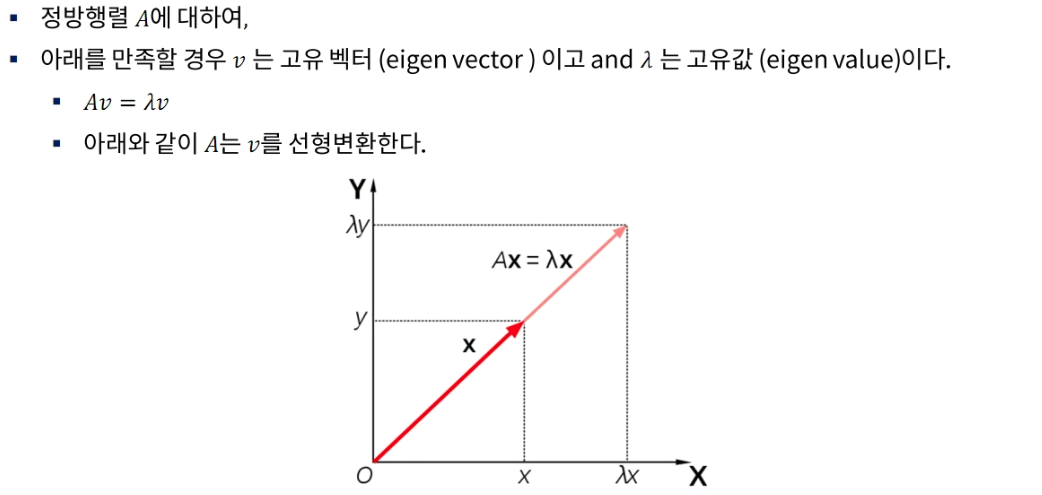

https://upload.wikimedia.org/wikipedia/commons/0/06/Eigenvectors.gif

Image Reference: https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors

  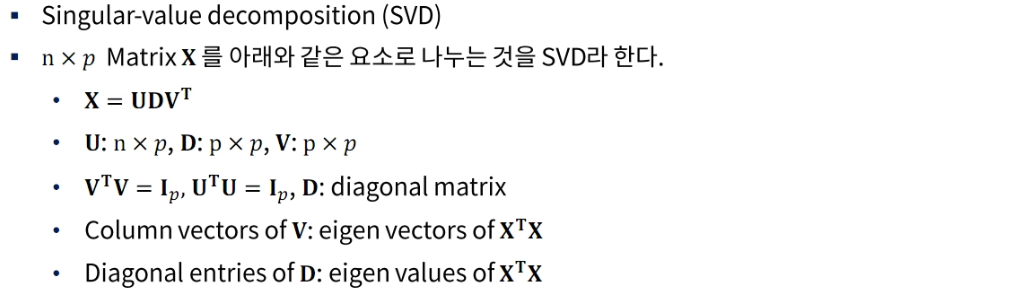

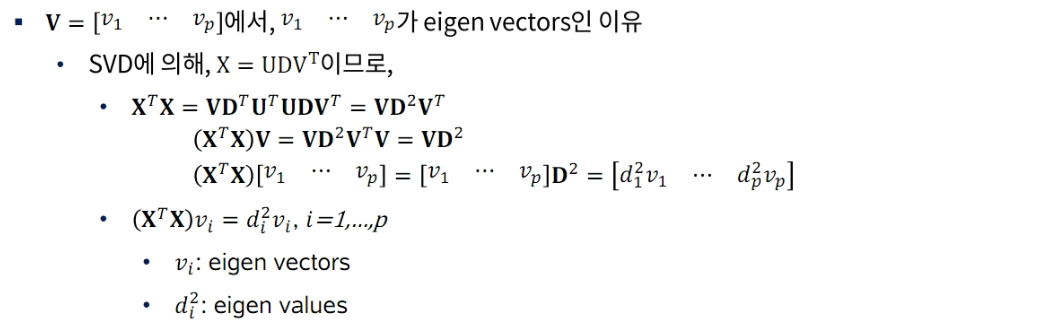

### 문제 5. [PCA] PCA를 위한 Singular Value Decomposition (SVD) 진행 

In [ ]:
## (문제) X_1 데이터의 각 변수를 평균이 0이 되도록 만들어 mX에 저장합니다.이렇게 진행하면 mX의 Quadratic 형태가 Covariance와 상수배가 됩니다.


In [ ]:
## (문제) numpy.cov를 활용하여 mX의 공분산행렬을 구하여 A에 저장합니다.


In [ ]:
## (문제) numpy.linalg.svd를 활용하여 SVD를 진행하여 aU, aD, aY에 저장합니다.


In [ ]:
## (문제) PC score를 구해내어서 XY에 저장합니다. mX 행렬에 eigenvector를 곱하여 구합니다.


In [ ]:
plt.scatter(mX[:,0],mX[:,1],color="black")
plt.scatter(XV[:,0],XV[:,1],color="green")
origin = (0, 0) 
plt.quiver(origin[0],origin[1], aV[0,0], aV[1,0], color=['r','b'], scale=3)
plt.quiver(origin[0],origin[1], aV[0,1], aV[1,1], color=['r','b'], scale=3)
plt.show()

### 문제 6. [PCA] PCA 진행 및 결과 해석

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
## (문제) sklearn.decomposition.PCA 활용하여 PCA를 진행한 후 pca에 저장합니다.


In [ ]:
## (문제) PC score를  PCscore에 저장하고 앞서 구한 XV와 같거나 부호만 다름을 확인합니다.


In [ ]:
## (문제) Eigen vector를 eigens_v에 저장하고 앞서 구한 aV와 같거나 부호만 다름을 확인합니다.


In [ ]:
## (문제) Eigen values를 구하고  앞서 구한 aD와 같음을 확인합니다.


In [ ]:
mX=X_1
for i in range(X_1.shape[1]):
    mX[:,i]=mX[:,i]-np.mean(X_1[:,i])

plt.scatter(mX[:,0],mX[:,1],color="black")
plt.scatter(PCscore[:,0],PCscore[:,1],color="green")
origin = (0,0) # origin point
plt.quiver(*origin, eigens_v[0,0], eigens_v[1,0], color=['r','b'], scale=3)
plt.quiver(*origin, eigens_v[0,1], eigens_v[1,1], color=['r','b'], scale=3)
plt.show()

### 문제 7. [PCA] PC를 활용한 차원 축소

In [ ]:
## (문제) eigen value를 barplot으로 표현하여 PC1과 PC2의 eigen value 값의 차이를 비교합니다.
label = ['PC1', 'PC2']
index = np.arange(len(label))


In [ ]:
plt.scatter(PCscore[:,0],PCscore[:,1])
plt.show()

In [ ]:
## (문제) PC1 만을 활용하여 KMeans clustering을 진행한 후 해당 클러스터로 색상을 넣어 X_1의 Scatter plot을 그립니다.
# 아래 PC1_matrix를 활용합니다.


##Step 4. 비선형 관계 데이터에의 적용

### 문제 8. K-means의 비선형 관계 데이터에의 적용

In [ ]:
## (문제) 비선형 관계 데이터인 X_2를 바탕으로 sklearn.cluster.KMeans를 활용하여 클러스터를 생성한 후
# seaborn.scatterplot을 이용하고 클러스터별 color_code를 적용하여 플랏을 그립니다.
color_code = {0:'Orange', 1:'Skyblue'}
plt.figure(figsize=(7,7))


### 문제 9. PCA의 비선형 관계 데이터에의 적용

In [ ]:
## (문제) 비선형 관계 데이터인 X_2를 바탕으로 sklearn.decomposition.PCA 활용하여 PCA를 진행한 후
# PC score에 대하여 seaborn.scatterplot을 이용하고 클러스터별 color_code를 적용하여 플랏을 그립니다.
# 원본 데이터 (alpha=0.1)와 PC score (alpha=0.5)를 플랏을 함께 그린 뒤 비교하여 어떻게 변했는지를 살핍니다.


### 문제 10. Interleaving half circles 데이터 생성 및 K-means, PCA 적용

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
# (문제) sklearn.datasets.make_moons를 활용하여 n_samples=300, random_state=1을 적용하여 데이터 생성하여 X_3, y_3에 저장.


In [ ]:
# (문제) matplotlib.pyplot.scatter을 활용하고 아래의 클러스터별 color_code를 적용하여 플랏을 그립니다.
plt.figure(figsize=(7,7))
color_code = {0:'red', 1:'blue'}


In [ ]:
# (문제) 비선형 관계 데이터인 X_3를 바탕으로 sklearn.cluster.KMeans를 활용하여 클러스터를 생성한 후
# seaborn.scatterplot을 이용하고 클러스터별 color_code를 적용하여 플랏을 그립니다.
color_code = {0:'red', 1:'blue'}
plt.figure(figsize=(7,7))


In [ ]:
## (문제) 비선형 관계 데이터인 X_3를 바탕으로 sklearn.decomposition.PCA 활용하여 PCA를 진행한 후
# PC score에 대하여 seaborn.scatterplot을 이용하고 클러스터별 color_code를 적용하여 플랏을 그립니다.
# 원본 데이터 (alpha=0.1)와 PC score (alpha=0.5)를 비교하여 어떻게 변했는지를 살핍니다.


### 문제 11. Spiral 데이터 생성 및 K-means, PCA 적용

In [ ]:
!pip install git+https://github.com/lovit/synthetic_dataset

In [ ]:
from soydata.data import *

In [ ]:
# (문제) soydata.data.classification.make_spiral를 활용하여 n_samples_per_class=500,n_classes=2,
# n_rotations=3, gap_between_spiral=10, gap_between_start_point=1, noise=0.1 을 적용하여 데이터 생성하여 X_4, y_4에 저장.


In [ ]:
# (문제) matplotlib.pyplot.scatter을 활용하고 아래의 클러스터별 color_code를 적용하여 플랏을 그립니다
plt.figure(figsize=(7,7))
color_code = {0:'Orange', 1:'Skyblue'}


In [ ]:
# (문제) 비선형 관계 데이터인 X_4를 바탕으로 sklearn.cluster.KMeans를 활용하여 클러스터를 생성한 후
# seaborn.scatterplot을 이용하고 클러스터별 color_code를 적용하여 플랏을 그립니다.
color_code = {0:'Orange', 1:'Skyblue'}
plt.figure(figsize=(7,7))


In [ ]:
## (문제) 비선형 관계 데이터인 X_4를 바탕으로 sklearn.decomposition.PCA 활용하여 PCA를 진행한 후
# PC score에 대하여 seaborn.scatterplot을 이용하고 클러스터별 color_code를 적용하여 플랏을 그립니다.
# 원본 데이터 (alpha=0.1)와 PC score (alpha=0.5)를 비교하여 어떻게 변했는지를 살핍니다.


##Step 5. Kernel PCA

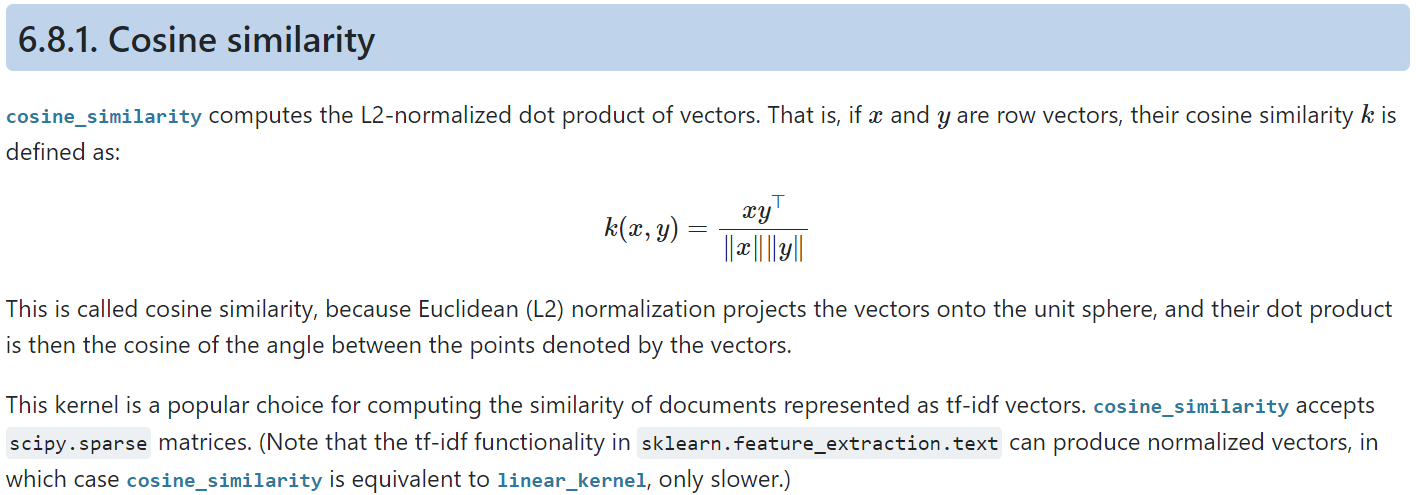

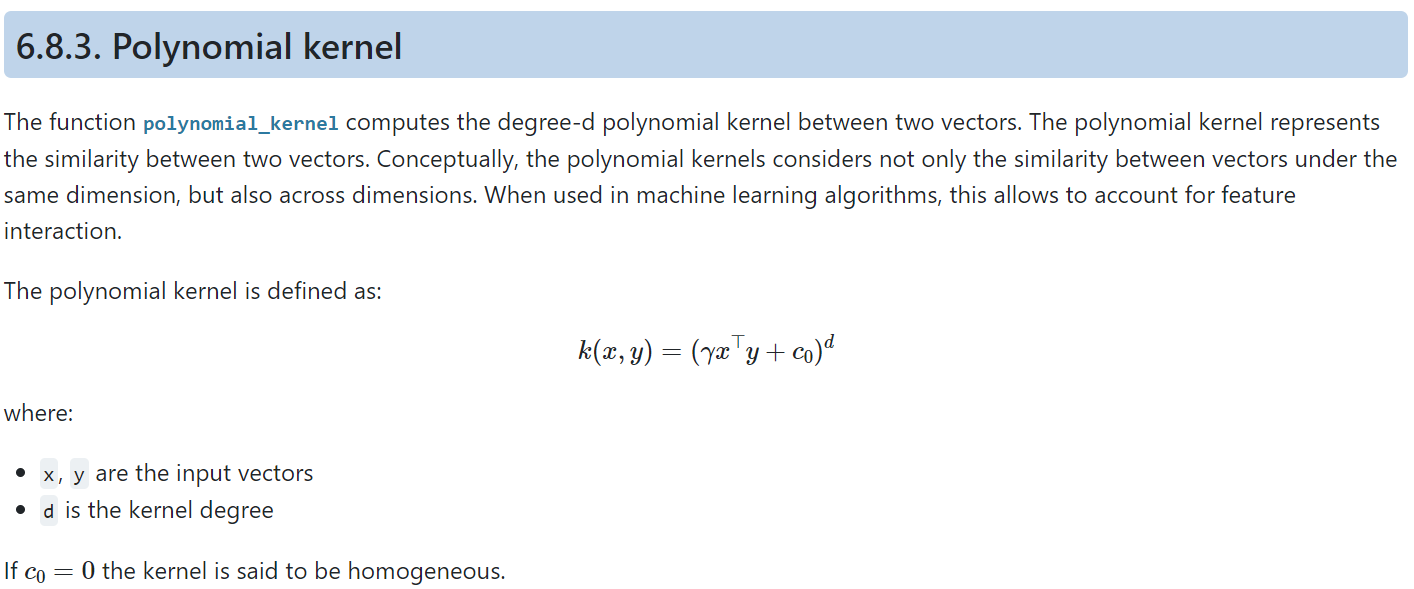

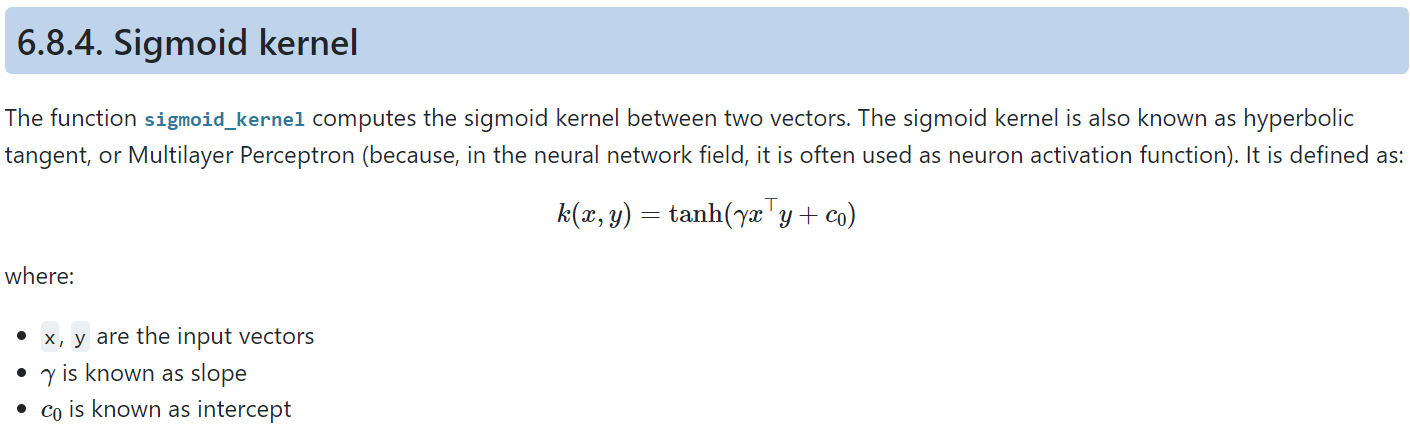

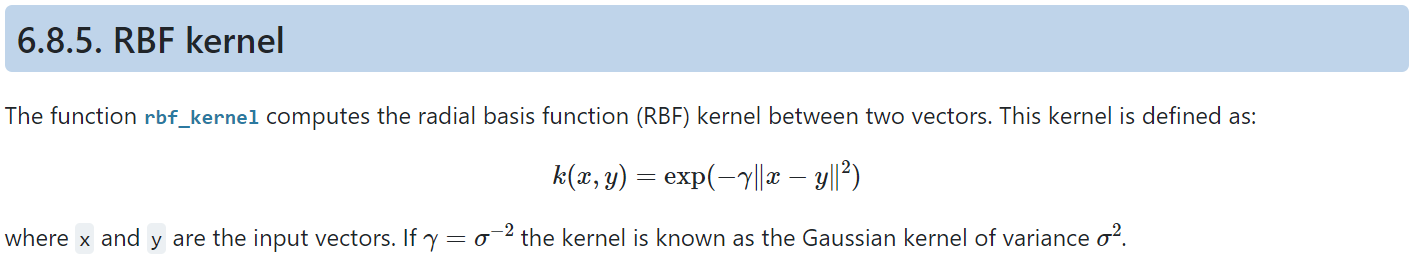

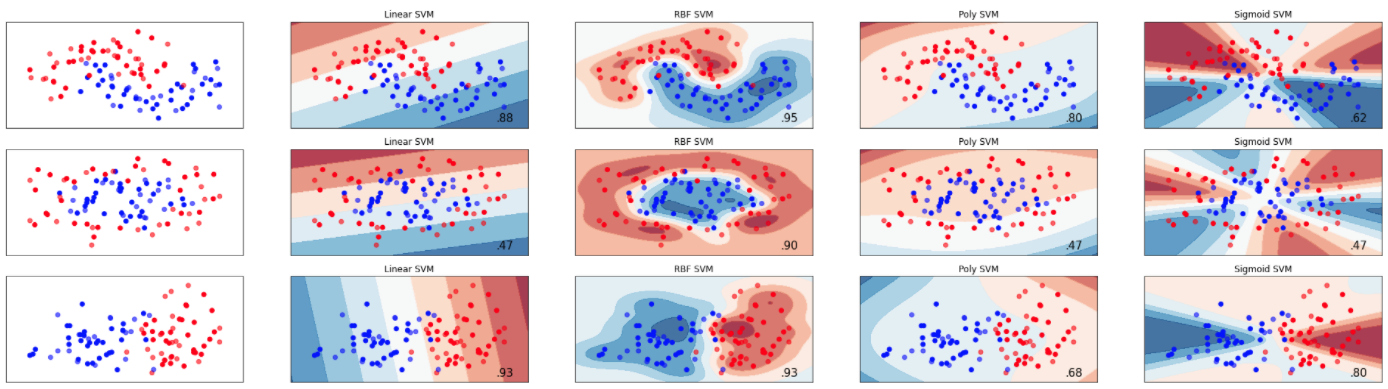

Image reference: https://scikit-learn.org/

https://www.geogebra.org/3d/evstbcjx




### 문제 12. [Kernel PCA] Kernel PCA를 활용하여 비선형 패턴 구분해내기 (Concentric circles)

- Radial basis kernel (rbf) PCA로 진행.
  - Gaussian kernel PCA로도 불립니다.

In [ ]:
## (문제)  데이터 X_2 (Concentric circles)를 이용하고 sklearn.decomposition.KernelPCA를 활용하여 KernelPCA를 진행하고 플랏을 그립니다.
# 커널은 rbf로 진행합니다.
# 비선형 관계 데이터를 선형으로 바꿔주는 적정한 gamma 값을 찾아야 합니다.
# 이를 결정하기 위하여 grid를 25개로 주고, 25개의 다양한 gamma값에 대하여 KenrnelPCA를 진행하고 플랏을 그린 후 적정 gamma에 대하여 고민해봅니다.
# 본 과정은 gamma의 범위를 좁혀가며 여러번 진행될 수 있습니다.
from sklearn.decomposition import KernelPCA


In [ ]:
## (문제) 적정한 Gamma를 결정하고 이를 바탕으로 플랏을 그립니다.


- Polynomial kernel PCA로 진행.

In [ ]:
## (문제)  데이터 X_2 (Concentric circles)를 이용하고 sklearn.decomposition.KernelPCA를 활용하여 KernelPCA를 진행하고 플랏을 그립니다.
# 커널은 poly로 진행합니다.
# 비선형 관계 데이터를 선형으로 바꿔주는 적정한 degree 값을 찾아야 합니다.
# 이를 결정하기 위하여 grid를 25개로 주고, 25개의 다양한 degree 값에 대하여 KenrnelPCA를 진행하고 플랏을 그린 후 적정 degree에 대하여 고민해봅니다.
# 본 과정은 degree의 범위를 좁혀가며 여러번 진행될 수 있습니다.
# 적정 degree를 찾았다면, gamma, coef0에 대해서도 마찬가지로 진행합니다.


- Sigmoid kernel PCA로 진행.

In [ ]:
## (문제)  데이터 X_2 (Concentric circles)를 이용하고 sklearn.decomposition.KernelPCA를 활용하여 KernelPCA를 진행하고 플랏을 그립니다.
# 커널은 sigmoid 진행합니다.
# 비선형 관계 데이터를 선형으로 바꿔주는 적정한 gamma 값을 찾아야 합니다.
# 이를 결정하기 위하여 grid를 25개로 주고, 25개의 다양한 gamma값에 대하여 KenrnelPCA를 진행하고 플랏을 그린 후 적정 gamma 값에 대하여 고민해봅니다.
# 본 과정은 gamma의 범위를 좁혀가며 여러번 진행될 수 있습니다.
# gamma가 결정되었다면 coef0값 또한 같은 방식으로 찾아줍니다.


### 문제 13. [Kernel PCA] Kernel PCA를 활용하여 비선형 패턴 구분해내기 (Interleaving half circles)


- Radial basis kernel (rbf) PCA로 진행.

In [ ]:
## (문제)  데이터 X_3 (Interleaving half circles)를 이용하고 sklearn.decomposition.KernelPCA를 활용하여 KernelPCA를 진행하고 플랏을 그립니다.
# 커널은 rbf로 진행합니다.
# 비선형 관계 데이터를 선형으로 바꿔주는 적정한 gamma 값을 찾아야 합니다.
# 이를 결정하기 위하여 grid를 25개로 주고, 25개의 다양한 gamma값에 대하여 KenrnelPCA를 진행하고 플랏을 그린 후 적정 gamma에 대하여 고민해봅니다.
# 본 과정은 gamma의 범위를 좁혀가며 여러번 진행될 수 있습니다.


- Polynomial kernel PCA로 진행.

In [ ]:
## (문제)  데이터 X_3 (Interleaving half circles)를 이용하고 sklearn.decomposition.KernelPCA를 활용하여 KernelPCA를 진행하고 플랏을 그립니다.
# 커널은 poly로 진행합니다.
# 비선형 관계 데이터를 선형으로 바꿔주는 적정한 degree 값을 찾아야 합니다.
# 이를 결정하기 위하여 grid를 25개로 주고, 25개의 다양한 degree 값에 대하여 KenrnelPCA를 진행하고 플랏을 그린 후 적정 degree에 대하여 고민해봅니다.
# 본 과정은 degree의 범위를 좁혀가며 여러번 진행될 수 있습니다.
# 적정 degree를 찾았다면, gamma, coef0에 대해서도 마찬가지로 진행합니다.


- Sigmoid kernel PCA로 진행.

In [ ]:
## (문제)  데이터 X_3 (Interleaving half circles)를 이용하고 sklearn.decomposition.KernelPCA를 활용하여 KernelPCA를 진행하고 플랏을 그립니다.
# 커널은 sigmoid 진행합니다.
# 비선형 관계 데이터를 선형으로 바꿔주는 적정한 gamma 값을 찾아야 합니다.
# 이를 결정하기 위하여 grid를 25개로 주고, 25개의 다양한 gamma값에 대하여 KenrnelPCA를 진행하고 플랏을 그린 후 적정 gamma 값에 대하여 고민해봅니다.
# 본 과정은 gamma의 범위를 좁혀가며 여러번 진행될 수 있습니다.
# 적정 gamma를 찾을 수 있었다면 coef0에 대해서도 마찬가지로 진행합니다.


### 문제 14. [Kernel PCA] Kernel PCA를 활용하여 비선형 패턴 구분해내기 (Spiral)

- Spiral의 경우는 완벽하게 구분되지 않을 수 있습니다.

- Radial basis kernel (rbf) PCA로 진행.

In [ ]:
## (문제)  데이터 X_4 (Spiral)를 이용하고 sklearn.decomposition.KernelPCA를 활용하여 KernelPCA를 진행하고 플랏을 그립니다.
# 커널은 rbf로 진행합니다.
# 비선형 관계 데이터를 선형으로 바꿔주는 적정한 gamma 값을 찾아야 합니다.
# 이를 결정하기 위하여 grid를 25개로 주고, 25개의 다양한 gamma값에 대하여 KenrnelPCA를 진행하고 플랏을 그린 후 적정 gamma에 대하여 고민해봅니다.
# 본 과정은 gamma의 범위를 좁혀가며 여러번 진행될 수 있습니다.


- Polynomial kernel PCA로 진행.

In [ ]:
## (문제)  데이터 X_4 (Spiral)를 이용하고 sklearn.decomposition.KernelPCA를 활용하여 KernelPCA를 진행하고 플랏을 그립니다.
# 커널은 poly로 진행합니다.
# 비선형 관계 데이터를 선형으로 바꿔주는 적정한 degree 값을 찾아야 합니다.
# 이를 결정하기 위하여 grid를 25개로 주고, 25개의 다양한 degree 값에 대하여 KenrnelPCA를 진행하고 플랏을 그린 후 적정 degree에 대하여 고민해봅니다.
# 본 과정은 degree의 범위를 좁혀가며 여러번 진행될 수 있습니다.
# 적정 degree를 찾았다면, gamma, coef0에 대해서도 마찬가지로 진행합니다.


- Sigmoid kernel PCA로 진행.

In [ ]:
## (문제)  데이터 X_4 (Spiral)를 이용하고 sklearn.decomposition.KernelPCA를 활용하여 KernelPCA를 진행하고 플랏을 그립니다.
# 커널은 sigmoid 진행합니다.
# 비선형 관계 데이터를 선형으로 바꿔주는 적정한 gamma 값을 찾아야 합니다.
# 이를 결정하기 위하여 grid를 25개로 주고, 25개의 다양한 gamma값에 대하여 KenrnelPCA를 진행하고 플랏을 그린 후 적정 gamma 값에 대하여 고민해봅니다.
# 본 과정은 gamma의 범위를 좁혀가며 여러번 진행될 수 있습니다.


##Step 6. PCA, Kernel PCA의 탐색적 데이터 분석에의 적용

- 아래와 같이 Steel Plate 예제를 준비합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 마운트가 제대로 진행되었는지 확인합니다. 
import os
os.chdir('/content/')
path = "./drive/MyDrive/P3C1"
file_list = os.listdir(path)

print ("file_list: {}".format(file_list))

file_list: ['Faults27x7_var', 'Faults.NNA']


In [ ]:
# 데이터를 읽어옵니다.
df = pd.read_csv("/content/drive/MyDrive/P3C1/Faults.NNA",  delimiter='\t', header=None)
df.head()

0     1        2        3     4   5    6   ...  27  28  29  30  31  32  33
0    42    50   270900   270944   267  17   44  ...   1   0   0   0   0   0   0
1   645   651  2538079  2538108   108  10   30  ...   1   0   0   0   0   0   0
2   829   835  1553913  1553931    71   8   19  ...   1   0   0   0   0   0   0
3   853   860   369370   369415   176  13   45  ...   1   0   0   0   0   0   0
4  1289  1306   498078   498335  2409  60  260  ...   1   0   0   0   0   0   0

[5 rows x 34 columns]

In [ ]:
# 칼럼 레이블을 읽어와서 데이터 프레임의 칼럼명으로 지정합니다.
attributes_name=pd.read_csv("/content/drive/MyDrive/P3C1/Faults27x7_var",  delimiter=' ', header=None)
df.columns=attributes_name[0]

In [ ]:
# 범주화 진행합니다.
conditions_bf=[df['Pastry'],
               df['Z_Scratch'],
               df['K_Scatch'],
               df['Stains'],
               df['Dirtiness'],
               df['Bumps'],
               df['Other_Faults']
               ]
conditions=list(map(lambda i: i.astype(bool), conditions_bf))
choices = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
df['class']=np.select(conditions,choices)

In [ ]:
color_code = {'Pastry':'Red', 'Z_Scratch':'Blue', 'K_Scatch':'Green', 'Stains':'Black', 'Dirtiness':'Pink', 'Bumps':'Brown', 'Other_Faults':'Gold'}
color_list = [color_code.get(i) for i in df.loc[:,'class']]
df_corTarget = df[['K_Scatch','X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']]
corr=df_corTarget.corr()

In [ ]:
choices2 = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps']
X_5_bf3 = df[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300',  'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']]

import random
random.seed(2000)
y_5_bf=df['class']
X_5_bf2 = X_5_bf3
X_5_bf=X_5_bf2.loc[y_5_bf.isin(choices2),:]
ind_row=[]
for i in range(0,len(choices2)):  
   ind_row.extend(random.sample(np.where(df['class']==choices2[i])[0].tolist(),55))

X_5=X_5_bf.iloc[ind_row,:]

In [ ]:
mapping_dic = {1:0, 3:1, 5:2}
y_5=y_5_bf[np.where(y_5_bf.isin(choices2))[0]][ind_row]
color_code = {'Pastry':'Red', 'Z_Scratch':'Blue', 'K_Scatch':'Green', 'Stains':'Black', 'Dirtiness':'Pink', 'Bumps':'Brown', 'Other_Faults':'Gold'}
y_color=[color_code.get(i) for i in y_5]

NameError: ignored

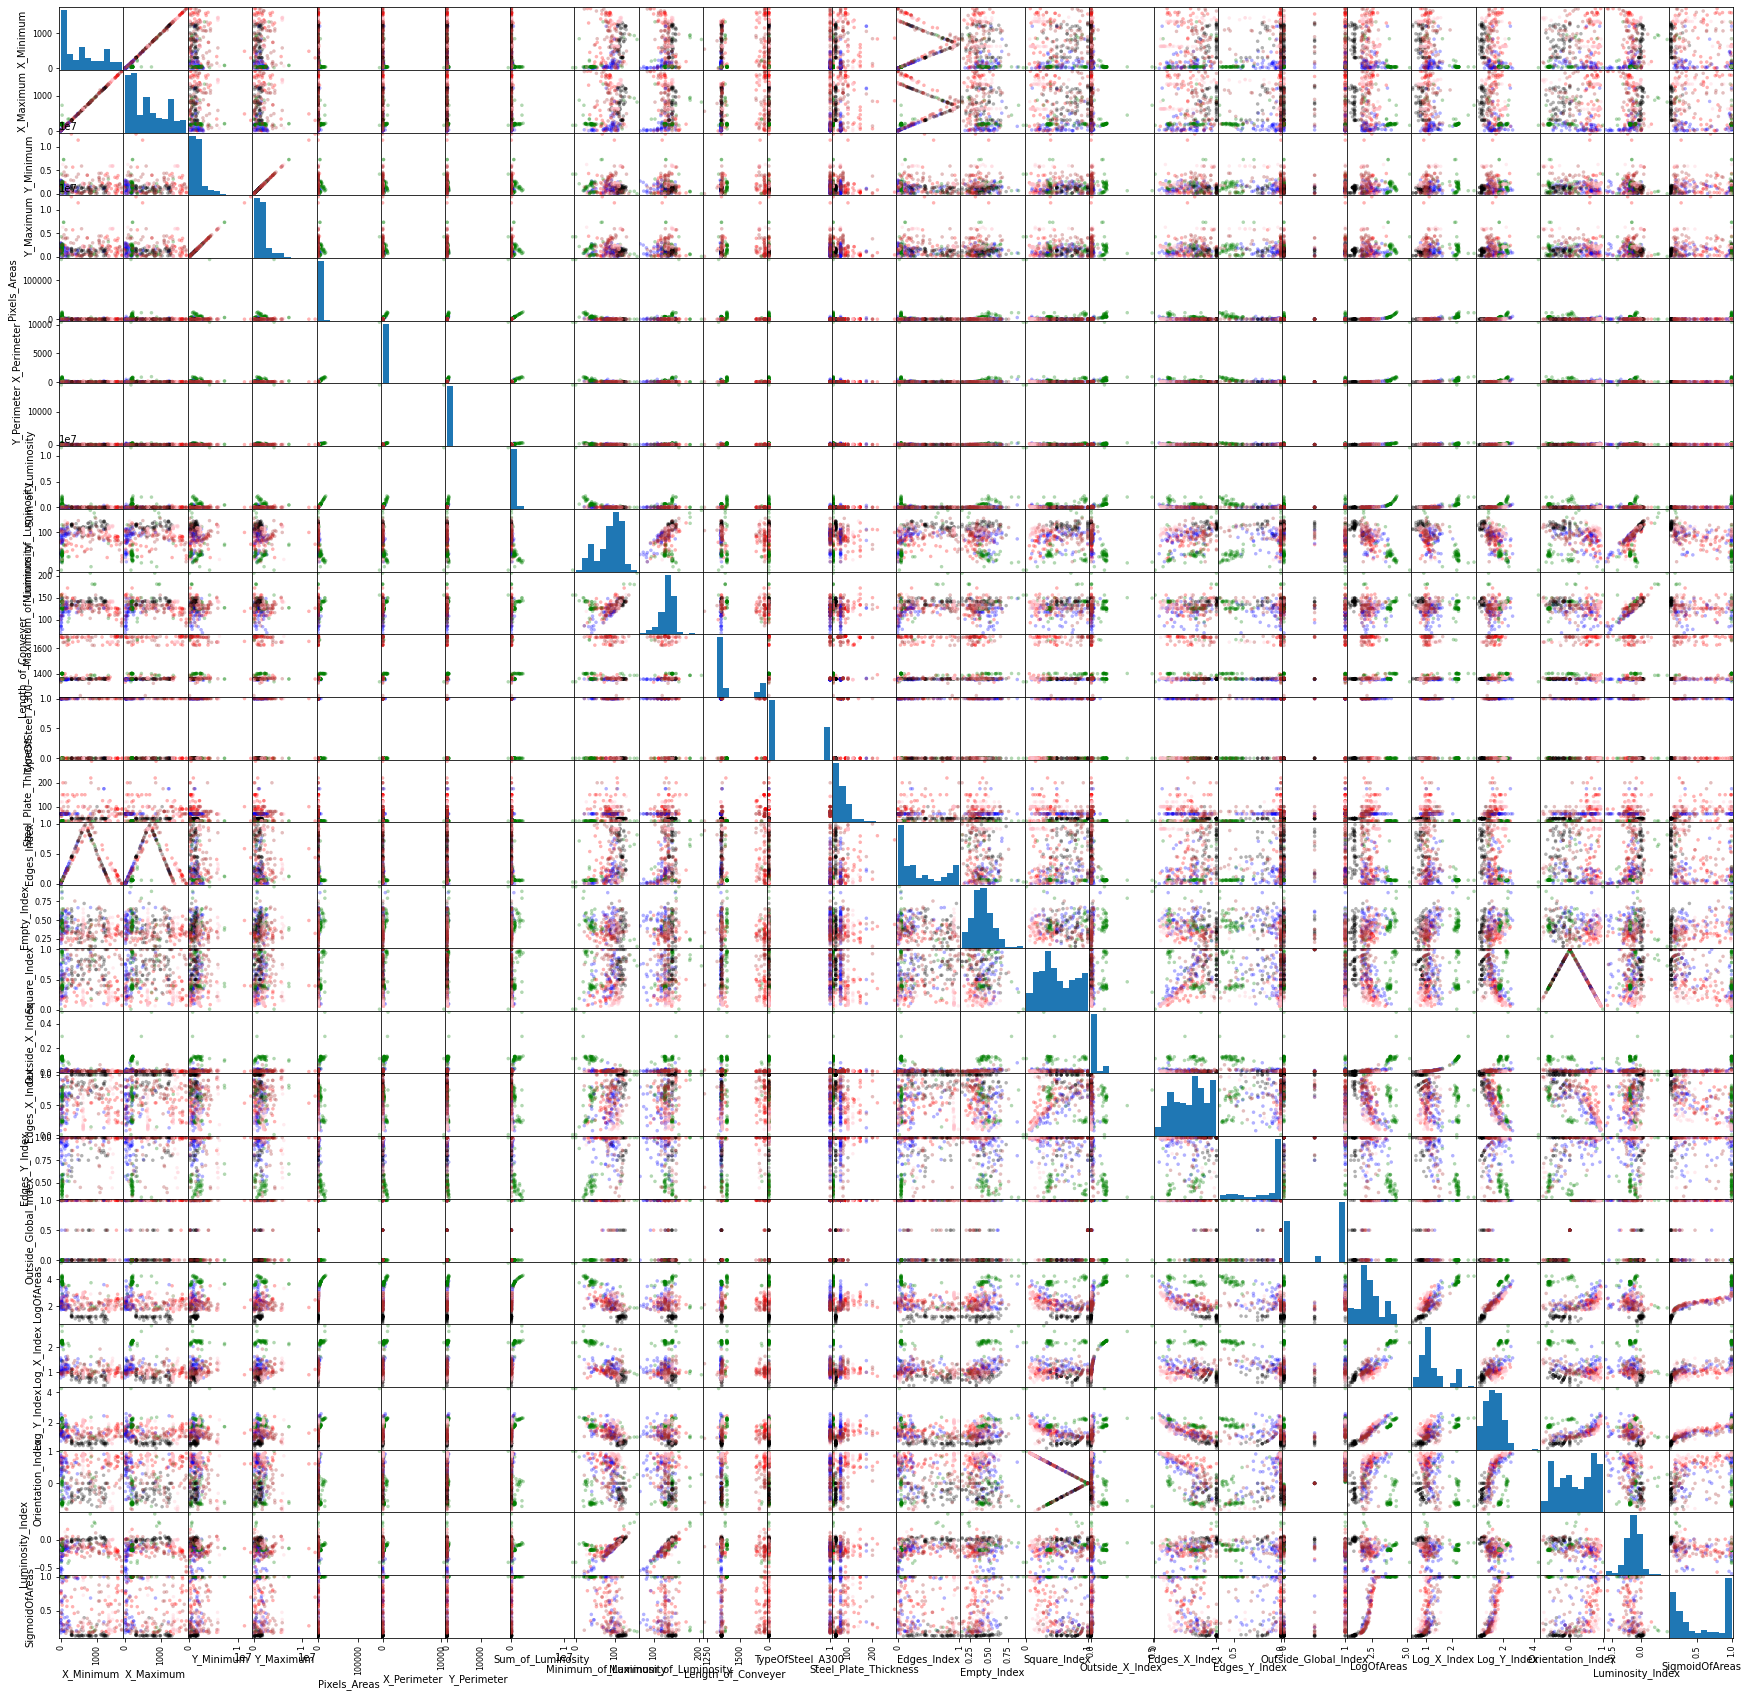

In [ ]:
# scatter plot을 그리고 대각원소에는 히스토그램을 출력해봅니다.
pd.plotting.scatter_matrix(X_5,
                                       c=y_color,
                                       figsize= [30,30],
                                       diagonal='hist',
                                       alpha=0.3,
                                       s = 50)
plt.show()

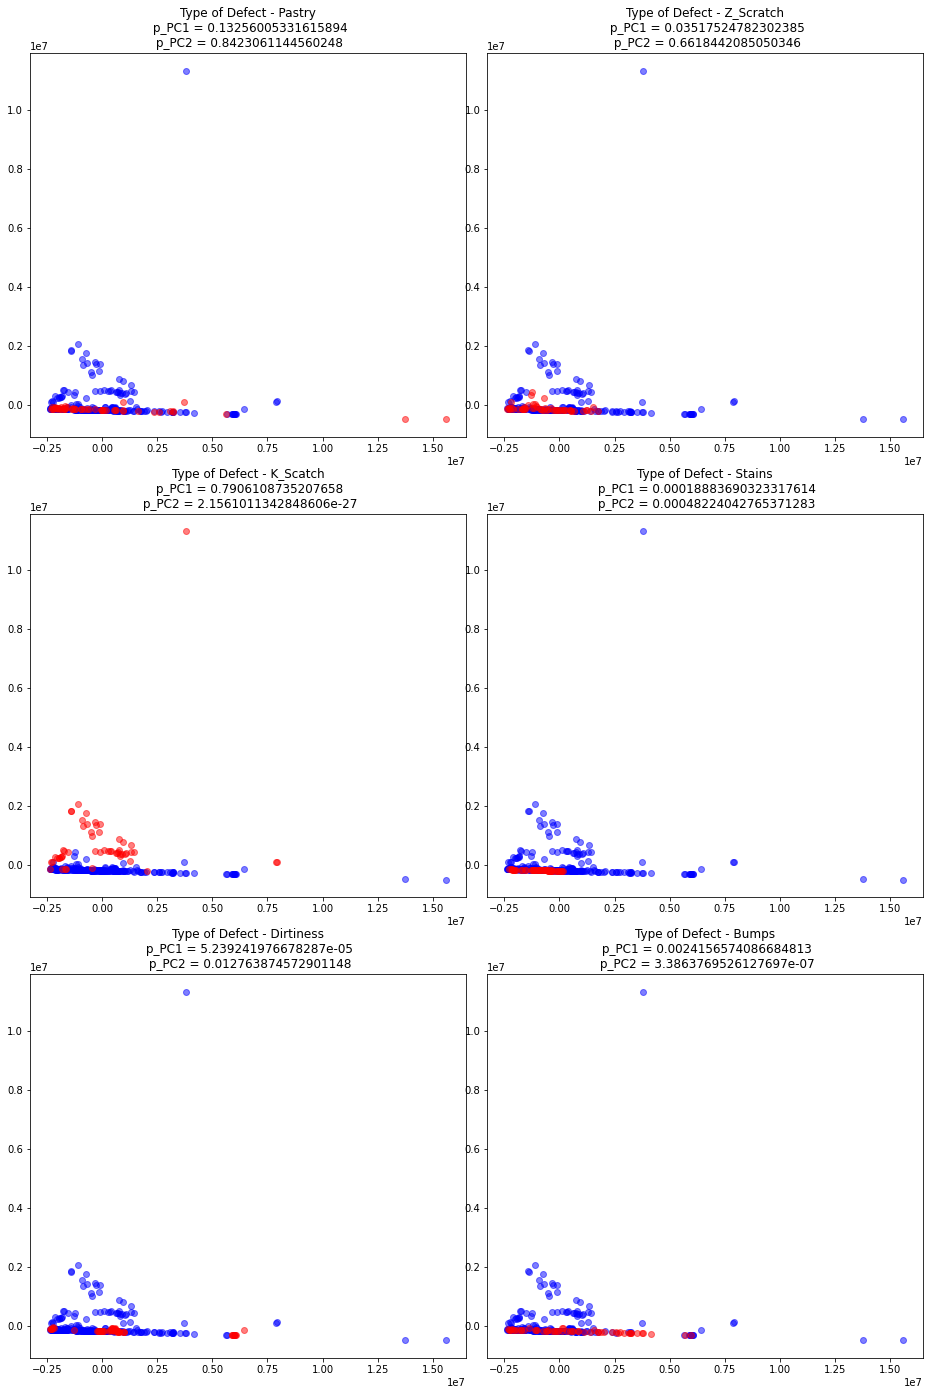

In [ ]:
# 우선 PCA를 진행하여 데이터가 전반적으로 어느 Defect와 선형관계에 있는지를 살펴봅니다.
from sklearn.decomposition import PCA
from scipy import stats
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X_5)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,24), sharex=False, sharey=False)

for n, ax in enumerate(axs.flatten()):  
    t, p = stats.ranksums(X_spca[y_5!=choices2[n], 0],X_spca[y_5==choices2[n], 0])
    t2, p2 = stats.ranksums(X_spca[y_5!=choices2[n], 1],X_spca[y_5==choices2[n], 1])  
    ax.scatter(X_spca[y_5!=choices2[n], 0], X_spca[y_5!=choices2[n], 1], color='blue', alpha=0.5)
    ax.scatter(X_spca[y_5==choices2[n], 0], X_spca[y_5==choices2[n], 1], color='red', alpha=0.5)
    ax.set_title('Type of Defect - ' + choices2[n]+"\n p_PC1 = " + str(p)+"\n p_PC2 = " + str(p2), size = 12)

plt.suptitle('', y = 0.95)
plt.subplots_adjust(wspace=0.05)
plt.show()

### 문제 15. 탐색적 데이터 분석을 위한 Kernel PCA

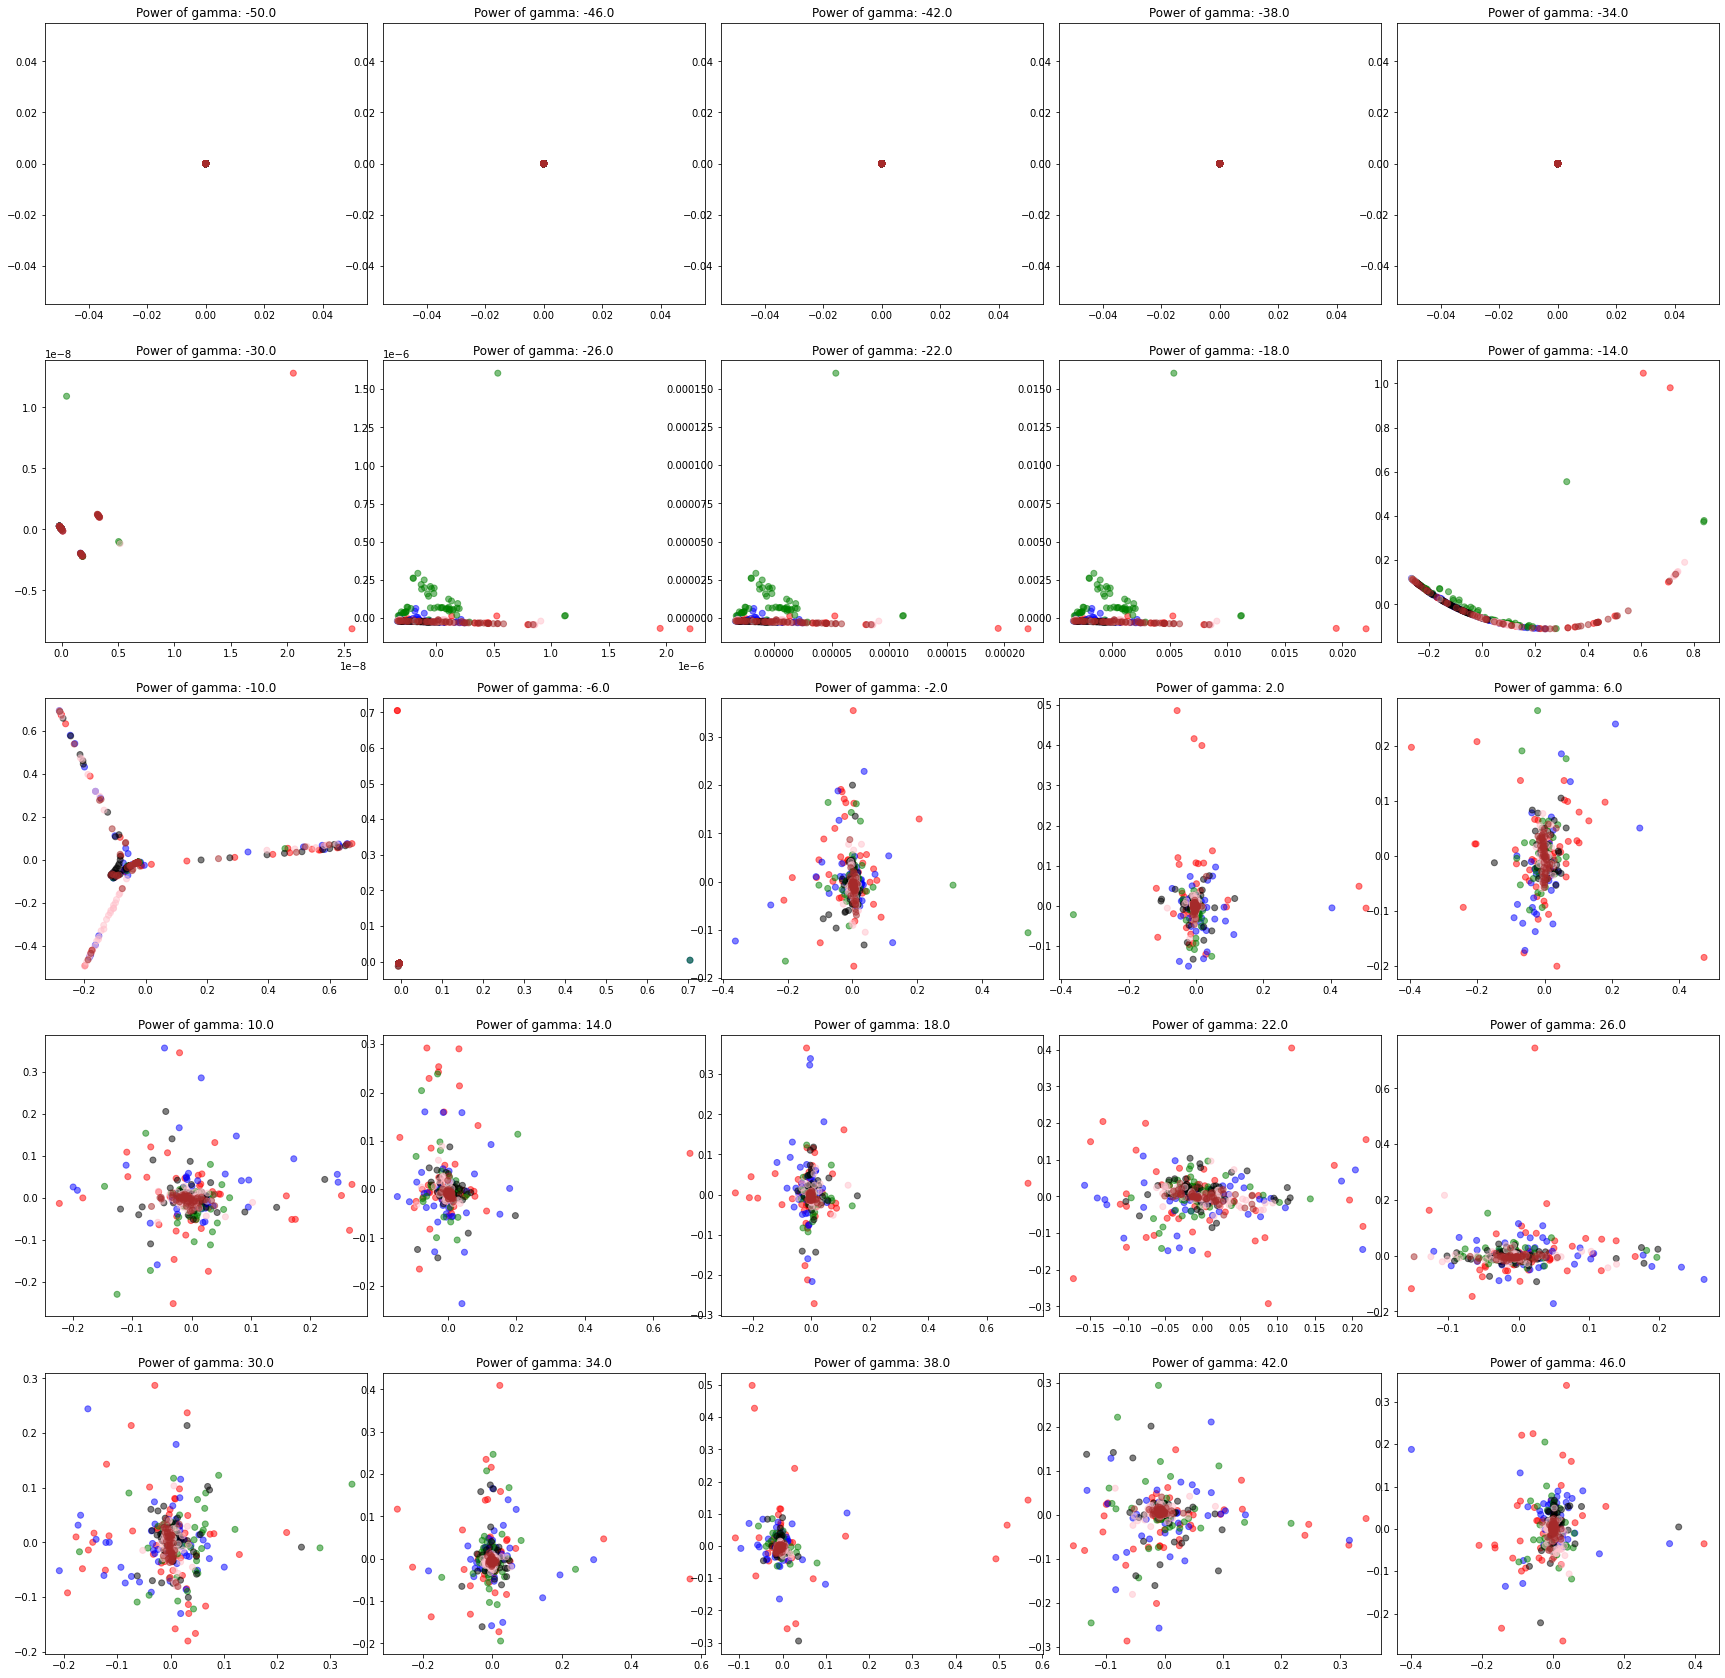

In [ ]:
## (문제) PCA결과 Pastry가 데이터와 선형 관계가 없는 Defect인 것으로 관측됩니다. Pastry와 데이터 간의 비선형적 상관관계가 있는지를 알아보고 싶습니다.
# 데이터 X_5 (Steel Plate Faults 데이터)를 이용하고 sklearn.decomposition.KernelPCA를 활용하여 KernelPCA를 진행하고 플랏을 그립니다.
# 커널은 rbf로 진행합니다.
# 비선형 관계 데이터를 선형으로 바꿔주는 적정한 gamma 값을 찾아야 합니다.
# 이를 결정하기 위하여 grid를 25개로 주고, 25개의 다양한 gamma값에 대하여 KenrnelPCA를 진행하고 플랏을 그린 후 적정 gamma에 대하여 고민해봅니다.
# 본 과정은 gamma의 범위를 좁혀가며 여러번 진행될 수 있습니다.
from sklearn.decomposition import KernelPCA
color_code2 = {'Pastry':'Red', 'Z_Scratch':'Blue', 'K_Scatch':'Green', 'Stains':'Black', 'Dirtiness':'Pink', 'Bumps':'Brown', 'Other_Faults':'Gold'}


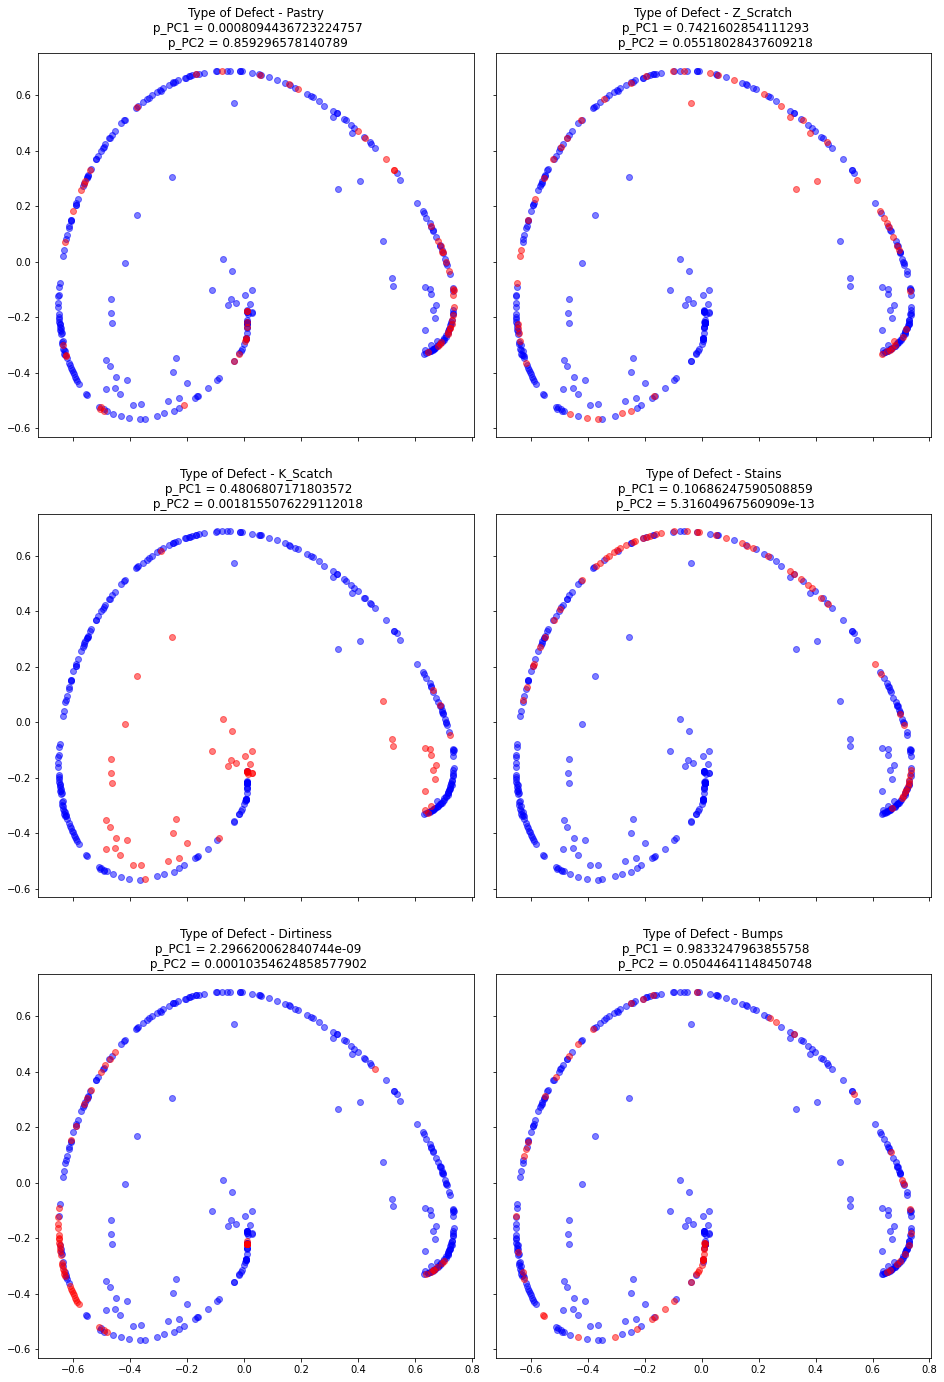

In [ ]:
# power of gamma는 -12로 지정하고 KernelPCA를 실시합ㄴ다.
g_power_val=-12
g_value=10**(g_power_val)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=g_value)
X_skernpca = scikit_kpca.fit_transform(X_5)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,24), sharex=True, sharey=True)

for n, ax in enumerate(axs.flatten()):
    t, p = stats.ranksums(X_skernpca[y_5!=choices2[n], 0],X_skernpca[y_5==choices2[n], 0])
    t2, p2 = stats.ranksums(X_skernpca[y_5!=choices2[n], 1],X_skernpca[y_5==choices2[n], 1])  
    ax.scatter(X_skernpca[y_5!=choices2[n], 0], X_skernpca[y_5!=choices2[n], 1], color='blue', alpha=0.5)
    ax.scatter(X_skernpca[y_5==choices2[n], 0], X_skernpca[y_5==choices2[n], 1], color='red', alpha=0.5)
    ax.set_title('Type of Defect - ' + choices2[n]+"\n p_PC1 = " + str(p)+"\n p_PC2 = " + str(p2), size = 12)


plt.suptitle('', y = 0.95)
plt.subplots_adjust(wspace=0.05)
plt.show()

In [ ]:
# Box plot을 통하여 PC1, PC2와 Pastry의 상관관계를 통계적으로 검정함.
Target_defect="Pastry"
arry_tmp=np.array([X_skernpca[:,0],X_skernpca[:,1],np.select([y_5==Target_defect,y_5!=Target_defect],[Target_defect,"Others"])])
tips=pd.DataFrame(arry_tmp.transpose(),columns=["PC1","PC2","x_val"])
tips['PC1'] = pd.to_numeric(tips['PC1'])
tips['PC2'] = pd.to_numeric(tips['PC2'])
tips.head()

from scipy import stats
t, p = stats.ttest_ind(tips['PC1'][tips['x_val']==Target_defect], tips['PC1'][tips['x_val']!=Target_defect])
t2, p2 = stats.ttest_ind(tips['PC2'][tips['x_val']==Target_defect], tips['PC2'][tips['x_val']!=Target_defect])
print("t_PC1 = " + str(round(t,5)),"/ p_PC1 = " + str(p))
print("t_PC2 = " + str(round(t2,5)),"/ p_PC2 = " + str(p2))

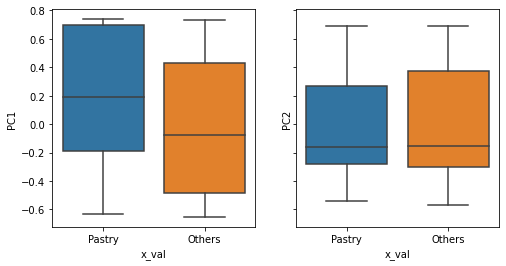

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharex=True, sharey=True)
for n, ax in enumerate(axs.flatten()):
    sns.boxplot(x="x_val", y="PC"+str(n+1),  data=tips, ax=axs[n])

plt.show()

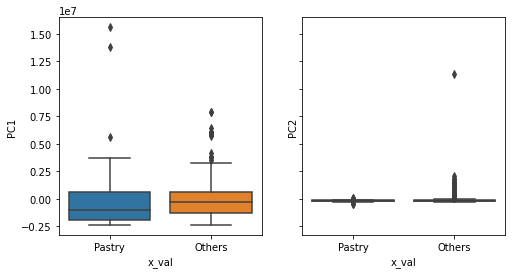

In [ ]:
arry_tmp2=np.array([X_spca[:,0],X_spca[:,1],np.select([y_5==Target_defect,y_5!=Target_defect],[Target_defect,"Others"])])
tips2=pd.DataFrame(arry_tmp2.transpose(),columns=["PC1","PC2","x_val"])
tips2['PC1'] = pd.to_numeric(tips2['PC1'])
tips2['PC2'] = pd.to_numeric(tips2['PC2'])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharex=True, sharey=True)
for n, ax in enumerate(axs.flatten()):
    sns.boxplot(x="x_val", y="PC"+str(n+1),  data=tips2, ax=axs[n])

plt.show()

## Chapter 2. 요약 및 마무리
- 학습한 것:
 - 기초 학습 내용은 비지도학습의 개념과 Clustering과 PCA의 이해 및 활용, 선형 패턴 데이터와 비선형 패턴 데이터를 구분하고 각 데이터에 맞는 분석 방법을 아는 것입니다.
 - 심화 학습 내용은 비선형 패턴 데이터를  Kernel PCA와 그 파라미터들을 조절하여 선형 패턴 데이터로 변화시키는 것과 그 과정을 이해하는 것입니다.

- 본 강의의 활용:
 - Clustering과 PCA, Kernel PCA를 통하여 데이터의 패턴과 특성을 파악하고 이러한 패턴과 연관이 되어있는 변수를 찾아 연구의 방향성을 잡거나 변수가 많을 경우 차원을 축소하거나, 일련의 과정을 통하여 모형 성능의 향상에 기여할 수 있습니다.  